In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
from tensorflow.keras import metrics

metrics = [
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    
]


In [9]:
# ==========================================
# 📁 DATASET CONFIGURATION
# ==========================================
data_dir = "/storage/dataset_balanced"
img_size = (224, 224)
batch_size = 64
seed = 123

# ✅ Split into train+val (90%) and test (10%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.10,  # Changed from 0.15 to 0.10
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.10,  # Changed from 0.15 to 0.10
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# ✅ Class info
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ==========================================
# 🔀 Split train_val (90%) into train (80%) & val (10%)
# ==========================================
train_val_count = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_count * (80/90))  # (80%/90%) ≈ 0.8889

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

# ✅ Verify splits
print(f"\nDataset splits:")
print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 49583 files belonging to 5 classes.
Using 44625 files for training.
Found 49583 files belonging to 5 classes.
Using 4958 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']

Dataset splits:
Train batches: 620
Val batches: 78
Test batches: 78


In [4]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_180layers_90acc.keras")


In [4]:
num_layers = len(model.layers)
print(f"Number of layers: {num_layers}")

Number of layers: 5


In [5]:
def count_all_layers(model):
    """Recursively count all layers in a model, including nested layers"""
    count = 0
    for layer in model.layers:
        count += 1
        # Check if this layer is itself a model with nested layers
        if hasattr(layer, 'layers'):
            count += count_all_layers(layer) - 1  # -1 to avoid double counting the nested model itself
    return count

# Count all layers recursively
total_layers = count_all_layers(model)
print(f"Total layers (including nested): {total_layers}")

# Show the top-level structure
print(f"\nTop-level layers: {len(model.layers)}")
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'layers'):
        nested_count = len(layer.layers)
        print(f"{i}: {layer.name} ({layer.__class__.__name__}) - contains {nested_count} nested layers")
    else:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")


Total layers (including nested): 389

Top-level layers: 5
0: efficientnetb3 (Functional) - contains 385 nested layers
1: global_average_pooling2d (GlobalAveragePooling2D)
2: dense (Dense)
3: dropout (Dropout)
4: dense_1 (Dense)


In [10]:
import tensorflow as tf
from tensorflow import keras

class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Optional class weights
    
    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calculate focal loss modulating factor
        focal_weight = tf.pow(1 - y_pred, self.gamma)
        
        # Apply focal loss
        focal_loss = focal_weight * cross_entropy
        
        # Apply class weights if provided
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        
        return tf.reduce_sum(focal_loss, axis=-1)


In [7]:
base_model = model.layers[0]  # This is the 'efficientnetb3' layer with 385 layers

# Freeze all layers first
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 180 layers
# 385 total layers - 180 layers to unfreeze = 205 layers to keep frozen
for layer in base_model.layers[-180:]:
    layer.trainable = True

# Verify the unfreezing
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_count}")
print(f"Total layers in base model: {len(base_model.layers)}")

Trainable layers in base model: 180
Total layers in base model: 385


Epoch 1/25


2025-11-12 07:46:45.555457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-12 07:46:49.148765: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-12 07:46:51.571967: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2cb9cf4e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 07:46:51.571998: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-11-12 07:46:51.590336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762933611.704572     104 device_compiler.h:186] Compiled clu

620/620 [==============================] - 271s 393ms/step - loss: 0.0480 - accuracy: 0.9424 - precision: 0.9452 - recall: 0.9389 - auc: 0.9972 - val_loss: 0.1127 - val_accuracy: 0.9035 - val_precision: 0.9064 - val_recall: 0.9009 - val_auc: 0.9918 - lr: 1.0000e-05
Epoch 2/25
620/620 [==============================] - 244s 391ms/step - loss: 0.0410 - accuracy: 0.9442 - precision: 0.9484 - recall: 0.9385 - auc: 0.9975 - val_loss: 0.1046 - val_accuracy: 0.9050 - val_precision: 0.9073 - val_recall: 0.9009 - val_auc: 0.9922 - lr: 1.0000e-05
Epoch 3/25
620/620 [==============================] - 241s 388ms/step - loss: 0.0400 - accuracy: 0.9448 - precision: 0.9496 - recall: 0.9388 - auc: 0.9975 - val_loss: 0.1000 - val_accuracy: 0.9039 - val_precision: 0.9083 - val_recall: 0.9009 - val_auc: 0.9923 - lr: 1.0000e-05
Epoch 4/25
620/620 [==============================] - 241s 386ms/step - loss: 0.0369 - accuracy: 0.9478 - precision: 0.9524 - recall: 0.9417 - auc: 0.9978 - val_loss: 0.1049 - val_

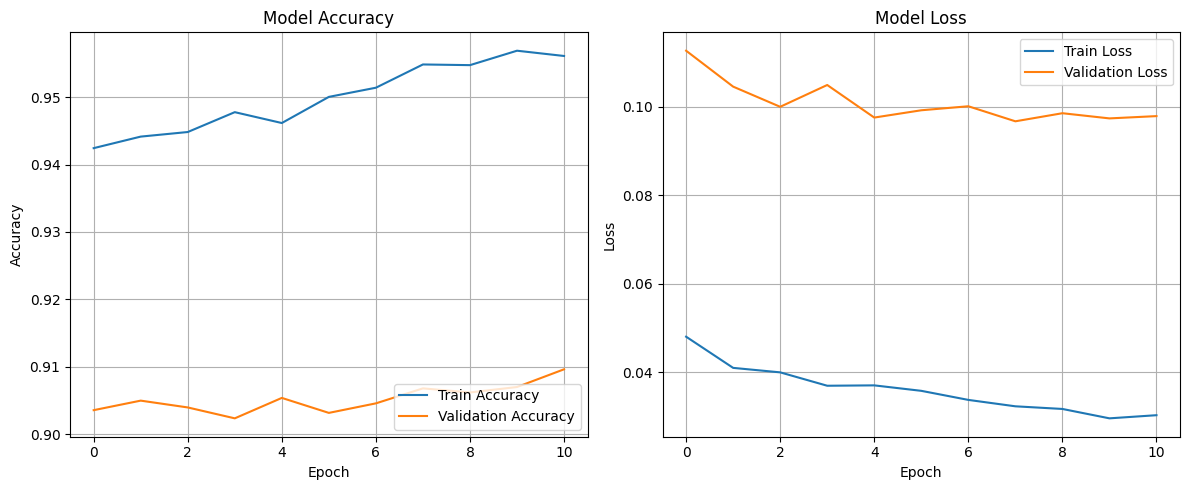

Total samples: 4945
Shape check - y_true: (4945,), y_pred: (4945,)


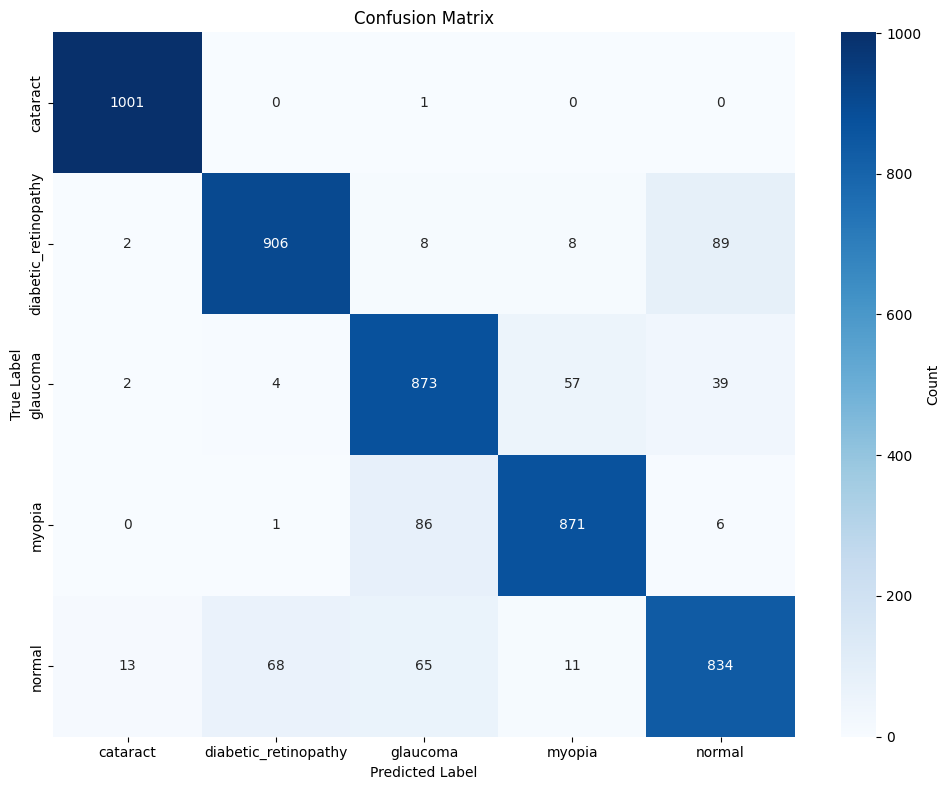


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9833    0.9990    0.9911      1002
diabetic_retinopathy     0.9254    0.8944    0.9096      1013
            glaucoma     0.8451    0.8954    0.8695       975
              myopia     0.9197    0.9035    0.9116       964
              normal     0.8616    0.8416    0.8515       991

            accuracy                         0.9070      4945
           macro avg     0.9070    0.9068    0.9067      4945
        weighted avg     0.9074    0.9070    0.9069      4945


PER-CLASS ACCURACY
cataract: 99.90% (1001/1002)
diabetic_retinopathy: 89.44% (906/1013)
glaucoma: 89.54% (873/975)
myopia: 90.35% (871/964)
normal: 84.16% (834/991)


In [ ]:

# Compile your model with focal loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=FocalLoss(gamma=2.0),
    metrics=metrics
)

# ==========================================
# 🎯 TRAIN THE MODEL
# ==========================================
epochs = 25  # Adjust as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

# ==========================================
# 📊 PLOT ACCURACY AND LOSS GRAPHS
# ==========================================
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# FIXED VERSION: Collect predictions and true labels together
y_true = []
y_pred_proba = []

# Iterate once through val_ds to get both labels and predictions
for images, labels in val_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Total samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


Evaluating model on test set...

Test set total samples: 4958
Shape check - y_true: (4958,), y_pred: (4958,)


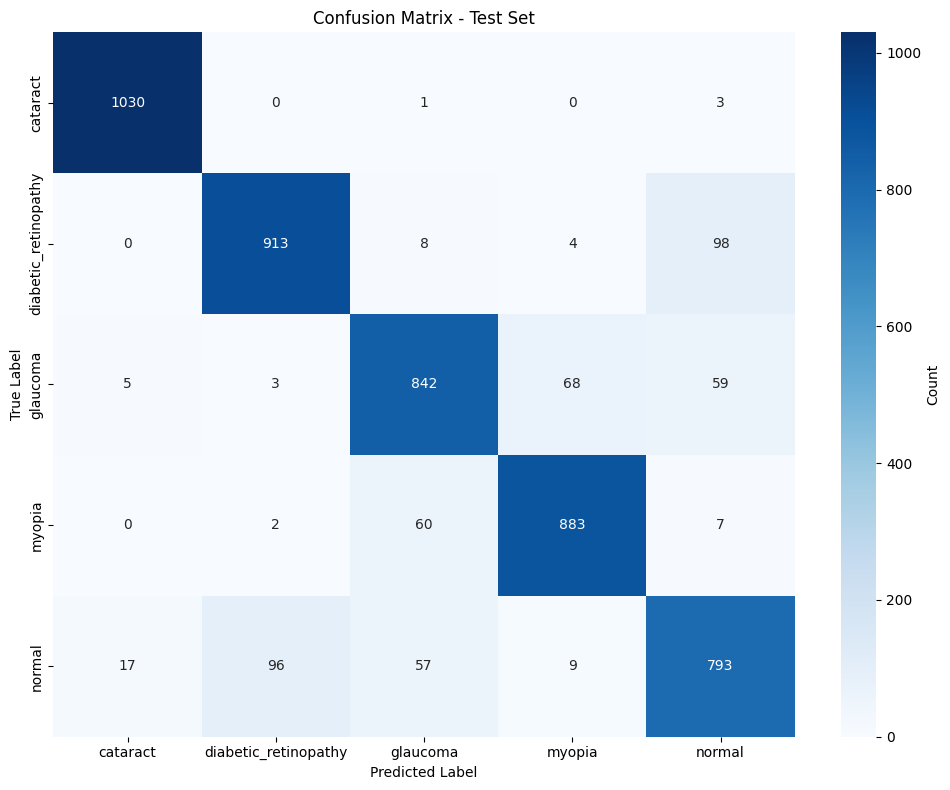


CLASSIFICATION REPORT - TEST SET
                      precision    recall  f1-score   support

            cataract     0.9791    0.9961    0.9875      1034
diabetic_retinopathy     0.9004    0.8925    0.8964      1023
            glaucoma     0.8698    0.8618    0.8658       977
              myopia     0.9160    0.9275    0.9217       952
              normal     0.8260    0.8158    0.8209       972

            accuracy                         0.8998      4958
           macro avg     0.8983    0.8988    0.8985      4958
        weighted avg     0.8992    0.8998    0.8994      4958


PER-CLASS ACCURACY - TEST SET
cataract: 99.61% (1030/1034)
diabetic_retinopathy: 89.25% (913/1023)
glaucoma: 86.18% (842/977)
myopia: 92.75% (883/952)
normal: 81.58% (793/972)

OVERALL TEST ACCURACY: 89.98%


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 🎯 EVALUATE ON TEST SET
# ==========================================
print("Evaluating model on test set...")

# Collect predictions and true labels from test set
y_true = []
y_pred_proba = []

# Iterate through test_ds to get both labels and predictions
for images, labels in test_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"\nTest set total samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY - TEST SET")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")

# ==========================================
# 📊 OVERALL TEST ACCURACY
# ==========================================
test_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"\n{'='*60}")
print(f"OVERALL TEST ACCURACY: {test_accuracy:.2f}%")
print(f"{'='*60}")



In [10]:
model_dN = load_model("//storage/DenseNet169_unfrozen_20layers_86acc.keras")

Starting Ensemble Evaluation...
Model 1: Sequential (EfficientNetB3)
Model 2: Functional (DenseNet169)
Generating predictions from both models...

Test set total samples: 4958

EFFICIENTNETB3 WITH FOCAL LOSS - TEST SET EVALUATION


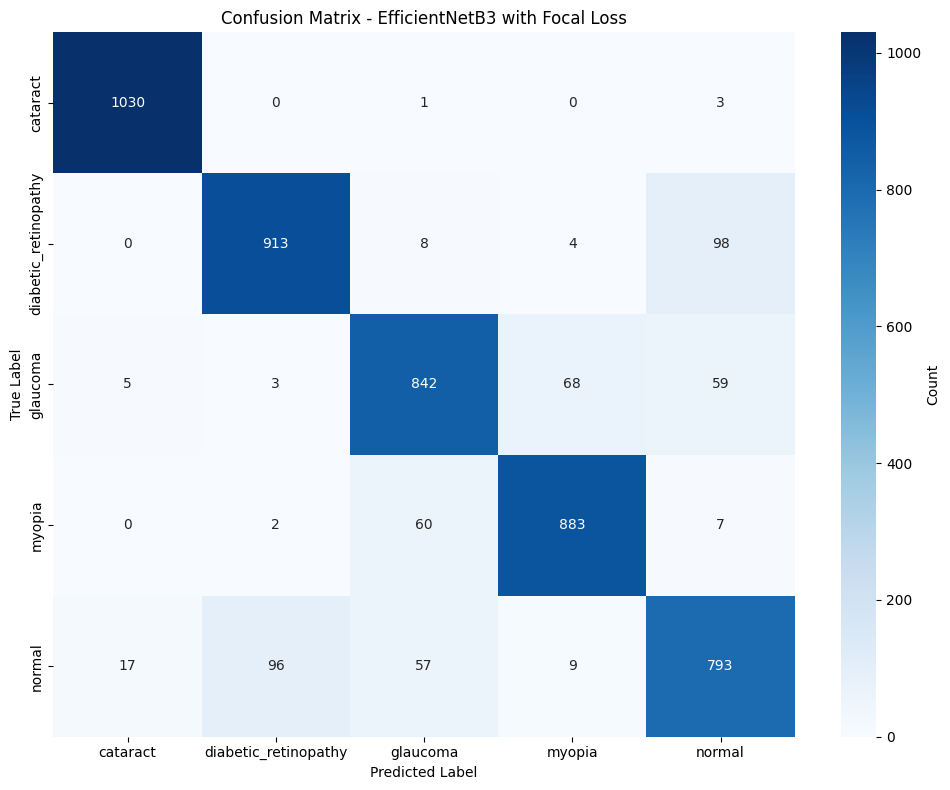


CLASSIFICATION REPORT
----------------------------------------------------------------------
                      precision    recall  f1-score   support

            cataract     0.9791    0.9961    0.9875      1034
diabetic_retinopathy     0.9004    0.8925    0.8964      1023
            glaucoma     0.8698    0.8618    0.8658       977
              myopia     0.9160    0.9275    0.9217       952
              normal     0.8260    0.8158    0.8209       972

            accuracy                         0.8998      4958
           macro avg     0.8983    0.8988    0.8985      4958
        weighted avg     0.8992    0.8998    0.8994      4958


PER-CLASS ACCURACY
----------------------------------------------------------------------
cataract: 99.61% (1030/1034)
diabetic_retinopathy: 89.25% (913/1023)
glaucoma: 86.18% (842/977)
myopia: 92.75% (883/952)
normal: 81.58% (793/972)

OVERALL TEST ACCURACY: 89.98%


DENSENET169 - TEST SET EVALUATION


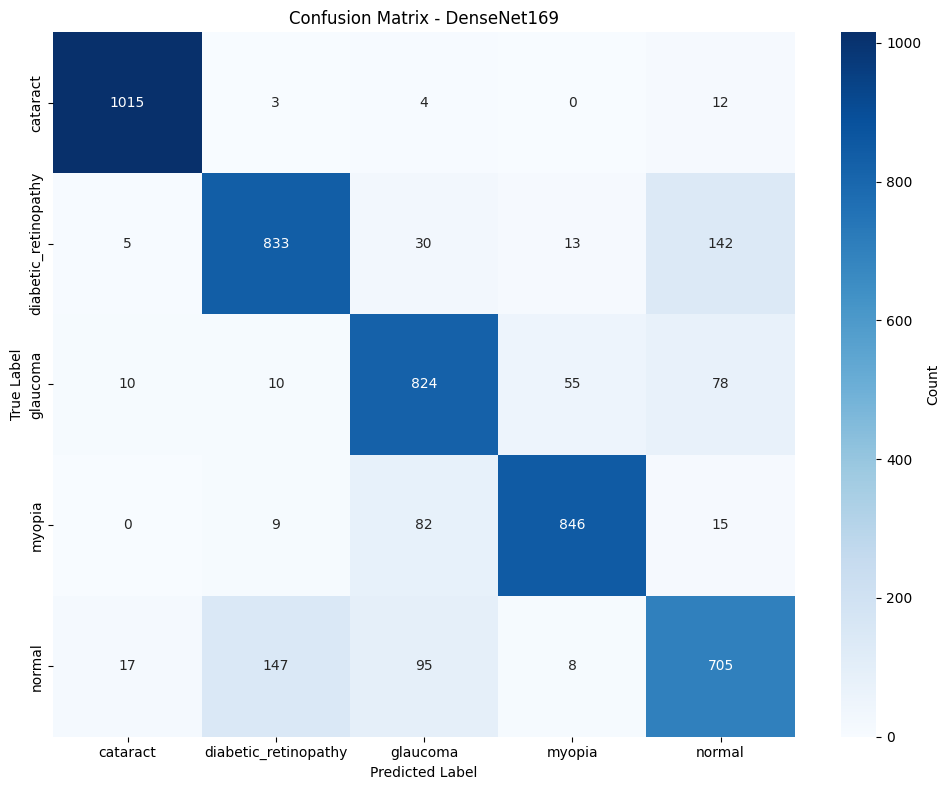


CLASSIFICATION REPORT
----------------------------------------------------------------------
                      precision    recall  f1-score   support

            cataract     0.9694    0.9816    0.9755      1034
diabetic_retinopathy     0.8313    0.8143    0.8227      1023
            glaucoma     0.7961    0.8434    0.8191       977
              myopia     0.9176    0.8887    0.9029       952
              normal     0.7405    0.7253    0.7328       972

            accuracy                         0.8518      4958
           macro avg     0.8510    0.8507    0.8506      4958
        weighted avg     0.8520    0.8518    0.8516      4958


PER-CLASS ACCURACY
----------------------------------------------------------------------
cataract: 98.16% (1015/1034)
diabetic_retinopathy: 81.43% (833/1023)
glaucoma: 84.34% (824/977)
myopia: 88.87% (846/952)
normal: 72.53% (705/972)

OVERALL TEST ACCURACY: 85.18%


ENSEMBLE (AVERAGE PREDICTIONS) - TEST SET EVALUATION


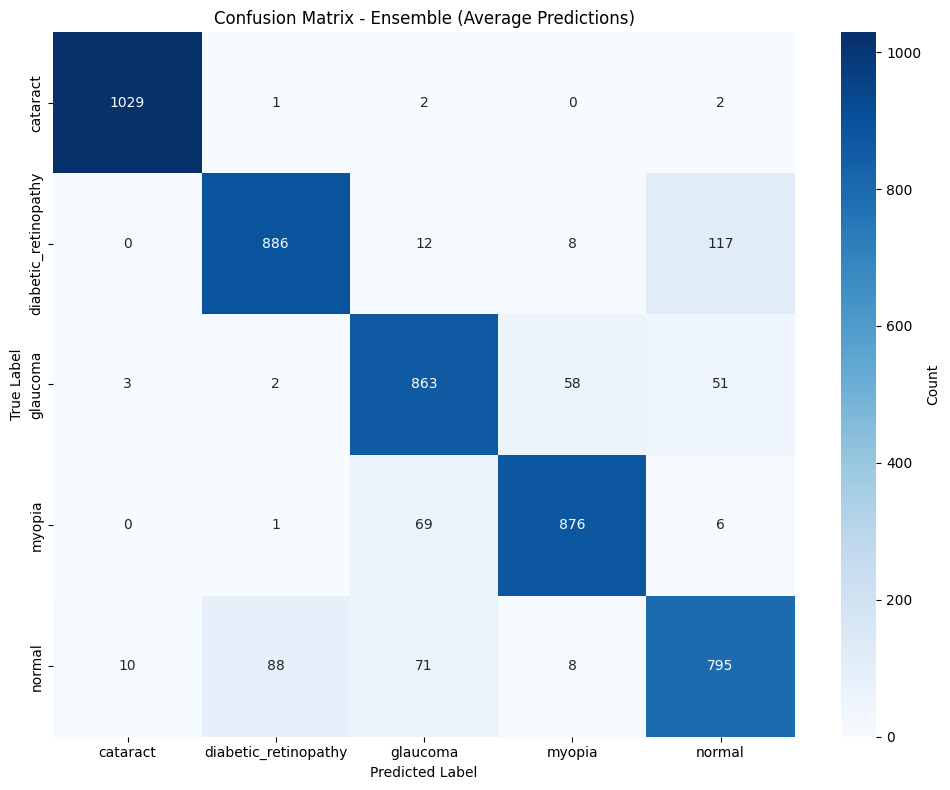


CLASSIFICATION REPORT
----------------------------------------------------------------------
                      precision    recall  f1-score   support

            cataract     0.9875    0.9952    0.9913      1034
diabetic_retinopathy     0.9059    0.8661    0.8856      1023
            glaucoma     0.8486    0.8833    0.8656       977
              myopia     0.9221    0.9202    0.9211       952
              normal     0.8187    0.8179    0.8183       972

            accuracy                         0.8973      4958
           macro avg     0.8966    0.8965    0.8964      4958
        weighted avg     0.8977    0.8973    0.8973      4958


PER-CLASS ACCURACY
----------------------------------------------------------------------
cataract: 99.52% (1029/1034)
diabetic_retinopathy: 86.61% (886/1023)
glaucoma: 88.33% (863/977)
myopia: 92.02% (876/952)
normal: 81.79% (795/972)

OVERALL TEST ACCURACY: 89.73%


FINAL COMPARISON SUMMARY
EfficientNetB3 (Focal Loss) Accuracy: 89.98%
Dense

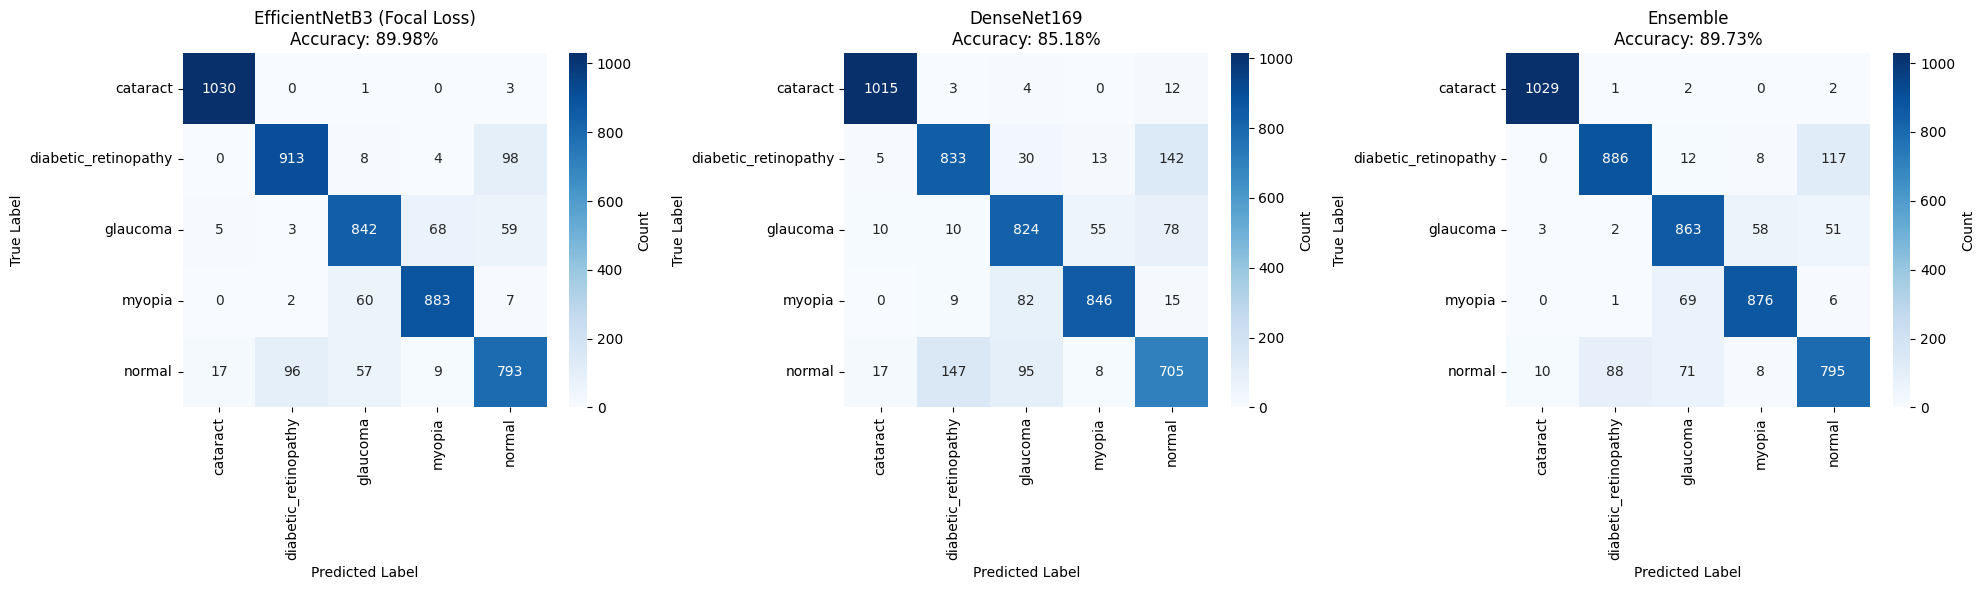


Comparison plot saved as 'ensemble_comparison.png'

PER-CLASS PERFORMANCE COMPARISON
Class                     EfficientNetB3  DenseNet169     Ensemble       
----------------------------------------------------------------------
cataract                   99.61%          98.16%          99.52%
diabetic_retinopathy       89.25%          81.43%          86.61%
glaucoma                   86.18%          84.34%          88.33%
myopia                     92.75%          88.87%          92.02%
normal                     81.58%          72.53%          81.79%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 🎯 ENSEMBLE PREDICTION FUNCTION
# ==========================================
def ensemble_predict(model1, model2, dataset, method='average'):
    """
    Create ensemble predictions from two models
    
    Args:
        model1: First model (e.g., EfficientNetB3)
        model2: Second model (e.g., DenseNet169)
        dataset: Test dataset to predict on
        method: 'average' or 'voting'
    
    Returns:
        y_true: True labels
        y_pred_ensemble: Ensemble predictions
        y_pred_model1: Model 1 predictions
        y_pred_model2: Model 2 predictions
    """
    y_true = []
    y_pred_proba_model1 = []
    y_pred_proba_model2 = []
    
    print("Generating predictions from both models...")
    
    for images, labels in dataset:
        # Get true labels
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        
        # Get predictions from both models
        pred1 = model1.predict(images, verbose=0)
        pred2 = model2.predict(images, verbose=0)
        
        y_pred_proba_model1.extend(pred1)
        y_pred_proba_model2.extend(pred2)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred_proba_model1 = np.array(y_pred_proba_model1)
    y_pred_proba_model2 = np.array(y_pred_proba_model2)
    
    # Create ensemble predictions
    if method == 'average':
        # Average the predicted probabilities
        y_pred_proba_ensemble = (y_pred_proba_model1 + y_pred_proba_model2) / 2
    elif method == 'voting':
        # Hard voting: convert to class predictions then vote
        pred1_classes = np.argmax(y_pred_proba_model1, axis=1)
        pred2_classes = np.argmax(y_pred_proba_model2, axis=1)
        # If models agree, use that prediction; if not, use model with higher confidence
        y_pred_proba_ensemble = np.where(
            pred1_classes[:, None] == pred2_classes[:, None],
            y_pred_proba_model1,
            np.where(
                np.max(y_pred_proba_model1, axis=1)[:, None] > np.max(y_pred_proba_model2, axis=1)[:, None],
                y_pred_proba_model1,
                y_pred_proba_model2
            )
        )
    
    # Get final predictions
    y_pred_model1 = np.argmax(y_pred_proba_model1, axis=1)
    y_pred_model2 = np.argmax(y_pred_proba_model2, axis=1)
    y_pred_ensemble = np.argmax(y_pred_proba_ensemble, axis=1)
    
    return y_true, y_pred_ensemble, y_pred_model1, y_pred_model2


# ==========================================
# 📊 EVALUATION FUNCTION
# ==========================================
def evaluate_model(y_true, y_pred, model_name, class_names, show_plot=True):
    """
    Evaluate a model and print metrics
    """
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} - TEST SET EVALUATION")
    print(f"{'='*70}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names,
                    cbar_kws={'label': 'Count'})
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    # Classification Report
    print(f"\nCLASSIFICATION REPORT")
    print("-" * 70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Per-Class Accuracy
    print(f"\nPER-CLASS ACCURACY")
    print("-" * 70)
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
        print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")
    
    # Overall Accuracy
    overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
    print(f"\n{'='*70}")
    print(f"OVERALL TEST ACCURACY: {overall_accuracy:.2f}%")
    print(f"{'='*70}\n")
    
    return overall_accuracy, cm


# ==========================================
# 🚀 RUN ENSEMBLE EVALUATION
# ==========================================
print("Starting Ensemble Evaluation...")
print(f"Model 1: {model.__class__.__name__} (EfficientNetB3)")
print(f"Model 2: {model_dN.__class__.__name__} (DenseNet169)")

# Get predictions from both models and ensemble
y_true, y_pred_ensemble, y_pred_model1, y_pred_model2 = ensemble_predict(
    model, model_dN, test_ds, method='average'
)

print(f"\nTest set total samples: {len(y_true)}")

# ==========================================
# 📊 EVALUATE EACH MODEL INDIVIDUALLY
# ==========================================

# Evaluate Model 1 (EfficientNetB3)
acc1, cm1 = evaluate_model(
    y_true, y_pred_model1, 
    "EfficientNetB3 with Focal Loss", 
    class_names, 
    show_plot=True
)

# Evaluate Model 2 (DenseNet169)
acc2, cm2 = evaluate_model(
    y_true, y_pred_model2, 
    "DenseNet169", 
    class_names, 
    show_plot=True
)

# Evaluate Ensemble
acc_ensemble, cm_ensemble = evaluate_model(
    y_true, y_pred_ensemble, 
    "Ensemble (Average Predictions)", 
    class_names, 
    show_plot=True
)

# ==========================================
# 📈 COMPARISON SUMMARY
# ==========================================
print("\n" + "="*70)
print("FINAL COMPARISON SUMMARY")
print("="*70)
print(f"EfficientNetB3 (Focal Loss) Accuracy: {acc1:.2f}%")
print(f"DenseNet169 Accuracy:                 {acc2:.2f}%")
print(f"Ensemble Accuracy:                    {acc_ensemble:.2f}%")
print(f"\nEnsemble Improvement over EfficientNetB3: {acc_ensemble - acc1:+.2f}%")
print(f"Ensemble Improvement over DenseNet169:    {acc_ensemble - acc2:+.2f}%")
print("="*70)

# ==========================================
# 📊 SIDE-BY-SIDE COMPARISON PLOT
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot confusion matrices side by side
cms = [cm1, cm2, cm_ensemble]
titles = ['EfficientNetB3 (Focal Loss)', 'DenseNet169', 'Ensemble']
accuracies = [acc1, acc2, acc_ensemble]

for idx, (cm, title, acc) in enumerate(zip(cms, titles, accuracies)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=axes[idx])
    axes[idx].set_title(f'{title}\nAccuracy: {acc:.2f}%')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved as 'ensemble_comparison.png'")

# ==========================================
# 🎯 PER-CLASS IMPROVEMENT ANALYSIS
# ==========================================
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Class':<25} {'EfficientNetB3':<15} {'DenseNet169':<15} {'Ensemble':<15}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    acc1_class = (cm1[i, i] / cm1[i, :].sum() * 100) if cm1[i, :].sum() > 0 else 0
    acc2_class = (cm2[i, i] / cm2[i, :].sum() * 100) if cm2[i, :].sum() > 0 else 0
    acc_ens_class = (cm_ensemble[i, i] / cm_ensemble[i, :].sum() * 100) if cm_ensemble[i, :].sum() > 0 else 0
    
    print(f"{class_name:<25} {acc1_class:>6.2f}%         {acc2_class:>6.2f}%         {acc_ens_class:>6.2f}%")

print("="*70)


In [5]:
# Unfreeze all layers
model.trainable = True

# Verify the change
print(f"Total trainable parameters: {model.count_params()}")

Total trainable parameters: 11573044


Epoch 1/25


2025-11-12 13:29:05.382766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-12 13:29:10.593981: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-12 13:29:13.929433: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9e5c5ae9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 13:29:13.929616: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-11-12 13:29:13.944771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762954154.050077      94 device_compiler.h:186] Compiled clu

620/620 [==============================] - 510s 744ms/step - loss: 0.2699 - accuracy: 0.8354 - precision: 0.8494 - recall: 0.8197 - auc: 0.9754 - val_loss: 0.1795 - val_accuracy: 0.8580 - val_precision: 0.8690 - val_recall: 0.8479 - val_auc: 0.9840 - lr: 1.0000e-05
Epoch 2/25
620/620 [==============================] - 452s 727ms/step - loss: 0.1442 - accuracy: 0.8704 - precision: 0.8870 - recall: 0.8484 - auc: 0.9869 - val_loss: 0.1459 - val_accuracy: 0.8726 - val_precision: 0.8815 - val_recall: 0.8588 - val_auc: 0.9870 - lr: 1.0000e-05
Epoch 3/25
620/620 [==============================] - 446s 717ms/step - loss: 0.1202 - accuracy: 0.8870 - precision: 0.9014 - recall: 0.8660 - auc: 0.9898 - val_loss: 0.1316 - val_accuracy: 0.8801 - val_precision: 0.8877 - val_recall: 0.8714 - val_auc: 0.9887 - lr: 1.0000e-05
Epoch 4/25
620/620 [==============================] - 449s 721ms/step - loss: 0.1012 - accuracy: 0.8980 - precision: 0.9088 - recall: 0.8813 - auc: 0.9920 - val_loss: 0.1253 - val_

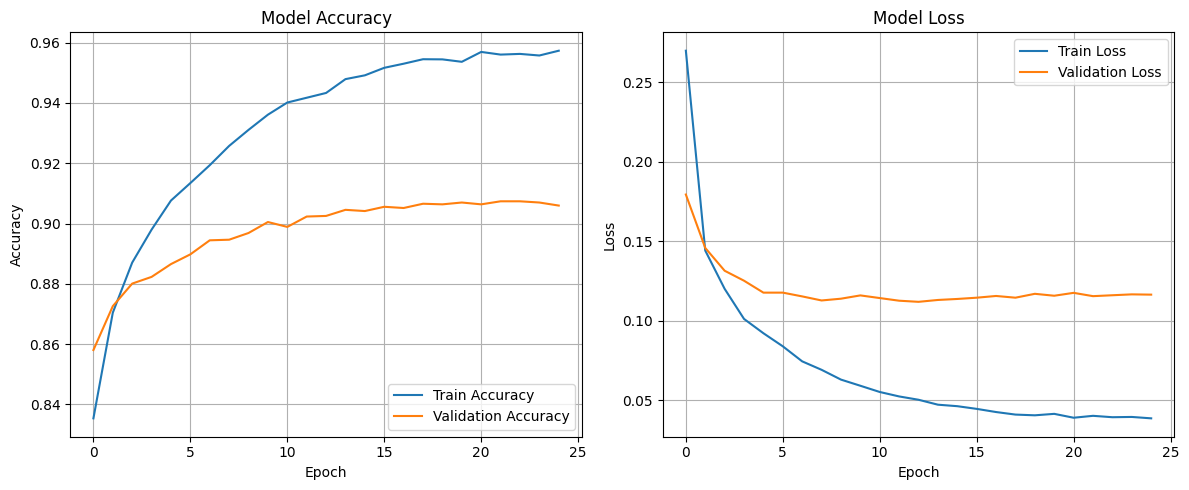

Total test samples: 4958
Shape check - y_true: (4958,), y_pred: (4958,)


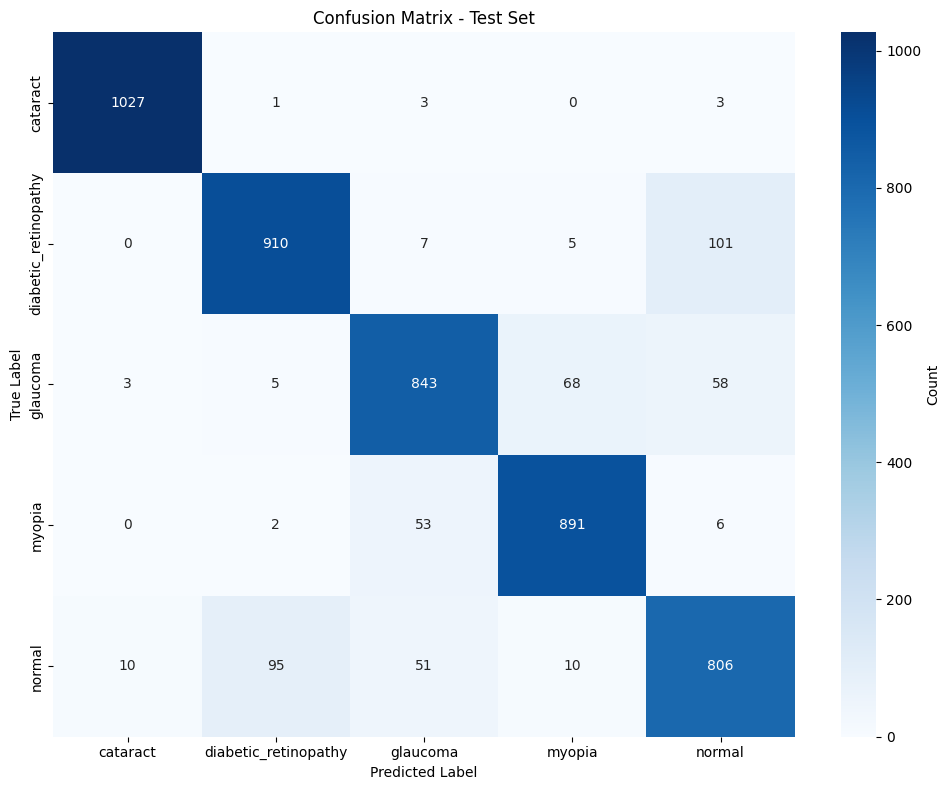


CLASSIFICATION REPORT - TEST SET
                      precision    recall  f1-score   support

            cataract     0.9875    0.9932    0.9904      1034
diabetic_retinopathy     0.8983    0.8895    0.8939      1023
            glaucoma     0.8809    0.8628    0.8718       977
              myopia     0.9148    0.9359    0.9252       952
              normal     0.8275    0.8292    0.8284       972

            accuracy                         0.9030      4958
           macro avg     0.9018    0.9022    0.9019      4958
        weighted avg     0.9028    0.9030    0.9028      4958


PER-CLASS ACCURACY - TEST SET
cataract: 99.32% (1027/1034)
diabetic_retinopathy: 88.95% (910/1023)
glaucoma: 86.28% (843/977)
myopia: 93.59% (891/952)
normal: 82.92% (806/972)


In [11]:

# Compile your model with focal loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=FocalLoss(gamma=1.5),
    metrics=metrics
)

# ==========================================
# 🎯 TRAIN THE MODEL
# ==========================================
epochs = 25  # Adjust as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[
        #EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2)
    ]
)

# ==========================================
# 📊 PLOT ACCURACY AND LOSS GRAPHS
# ==========================================
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# Collect predictions and true labels from test_ds
y_true = []
y_pred_proba = []

# Iterate once through test_ds to get both labels and predictions
for images, labels in test_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Total test samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY - TEST SET")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


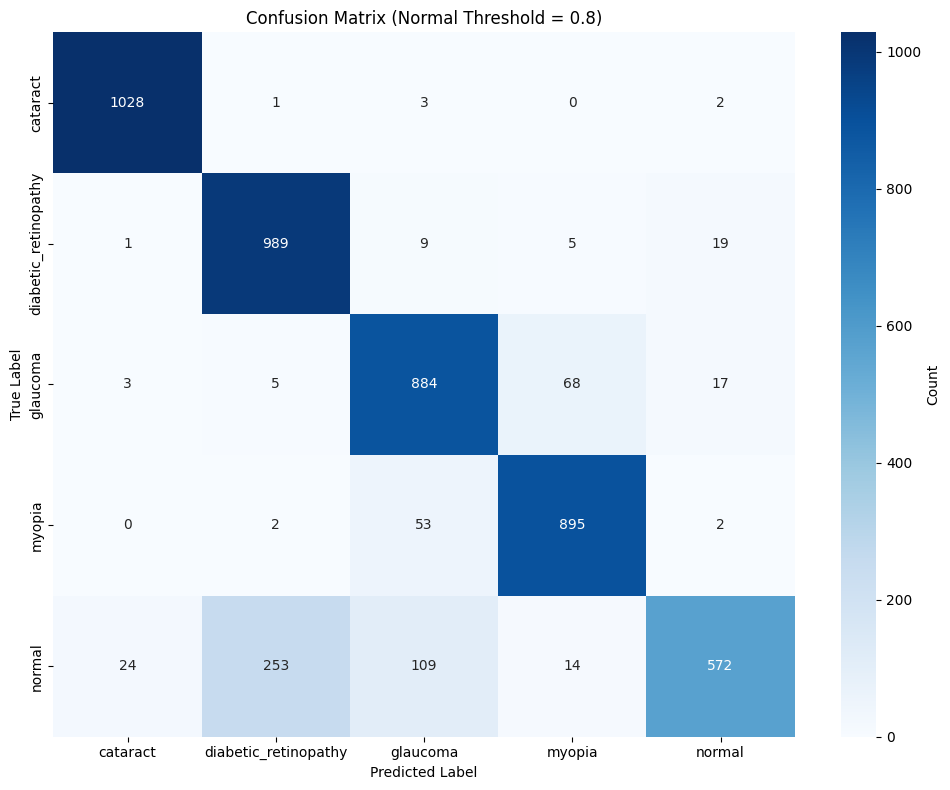


CLASSIFICATION REPORT (Normal Threshold = 0.8)
                      precision    recall  f1-score   support

            cataract     0.9735    0.9942    0.9837      1034
diabetic_retinopathy     0.7912    0.9668    0.8702      1023
            glaucoma     0.8355    0.9048    0.8688       977
              myopia     0.9114    0.9401    0.9255       952
              normal     0.9346    0.5885    0.7222       972

            accuracy                         0.8810      4958
           macro avg     0.8893    0.8789    0.8741      4958
        weighted avg     0.8892    0.8810    0.8752      4958


PER-CLASS ACCURACY (Normal Threshold = 0.8)
cataract: 99.42% (1028/1034)
diabetic_retinopathy: 96.68% (989/1023)
glaucoma: 90.48% (884/977)
myopia: 94.01% (895/952)
normal: 58.85% (572/972)


In [12]:
import numpy as np

y_true = []
y_pred_proba = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)


class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']
normal_index = class_names.index('normal')  # Usually 4


y_pred = []
for probs in y_pred_proba:
    if probs[normal_index] >= 0.8:
        y_pred.append(normal_index)
    else:
        # Exclude 'normal' from argmax selection
        other_probs = np.delete(probs, normal_index)
        pred_idx = np.argmax(other_probs)
        # Map back to the original class index (if normal_index is at the end)
        if pred_idx >= normal_index:
            pred_idx += 1
        y_pred.append(pred_idx)

y_pred = np.array(y_pred)


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Normal Threshold = 0.8)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Normal Threshold = 0.8)")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


print("\n" + "="*60)
print("PER-CLASS ACCURACY (Normal Threshold = 0.8)")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


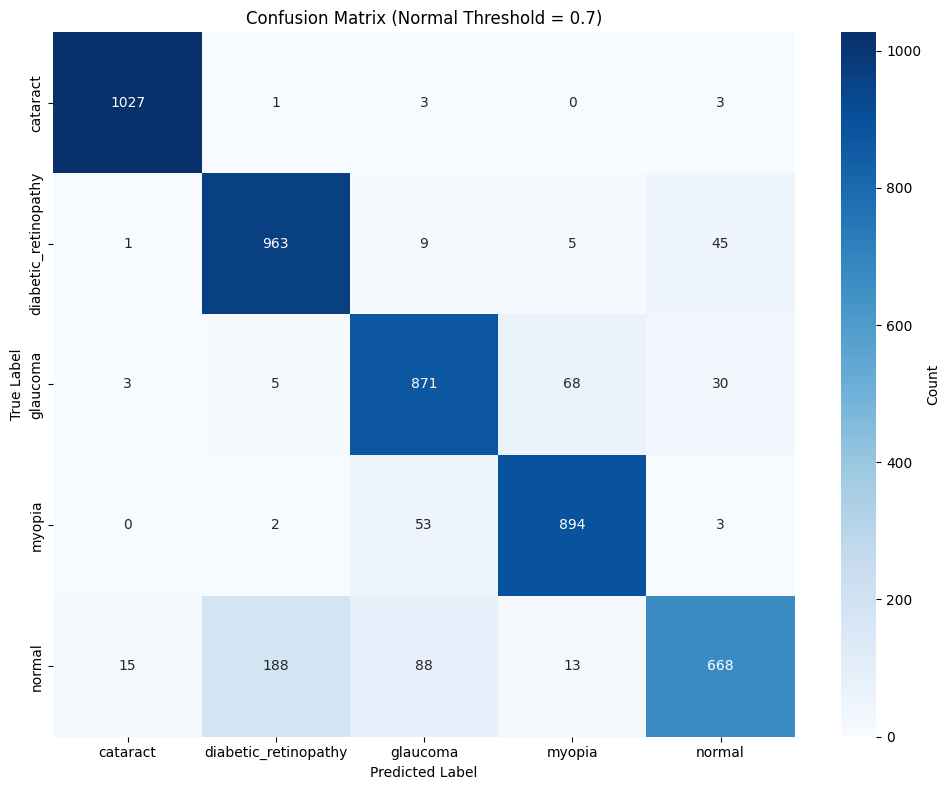


CLASSIFICATION REPORT (Normal Threshold = 0.7)
                      precision    recall  f1-score   support

            cataract     0.9818    0.9932    0.9875      1034
diabetic_retinopathy     0.8309    0.9413    0.8827      1023
            glaucoma     0.8506    0.8915    0.8706       977
              myopia     0.9122    0.9391    0.9255       952
              normal     0.8919    0.6872    0.7763       972

            accuracy                         0.8921      4958
           macro avg     0.8935    0.8905    0.8885      4958
        weighted avg     0.8938    0.8921    0.8895      4958


PER-CLASS ACCURACY (Normal Threshold = 0.7)
cataract: 99.32% (1027/1034)
diabetic_retinopathy: 94.13% (963/1023)
glaucoma: 89.15% (871/977)
myopia: 93.91% (894/952)
normal: 68.72% (668/972)


In [13]:
import numpy as np

y_true = []
y_pred_proba = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)


class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']
normal_index = class_names.index('normal')  # Usually 4


y_pred = []
for probs in y_pred_proba:
    if probs[normal_index] >= 0.7:
        y_pred.append(normal_index)
    else:
        # Exclude 'normal' from argmax selection
        other_probs = np.delete(probs, normal_index)
        pred_idx = np.argmax(other_probs)
        # Map back to the original class index (if normal_index is at the end)
        if pred_idx >= normal_index:
            pred_idx += 1
        y_pred.append(pred_idx)

y_pred = np.array(y_pred)


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Normal Threshold = 0.7)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Normal Threshold = 0.7)")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


print("\n" + "="*60)
print("PER-CLASS ACCURACY (Normal Threshold = 0.7)")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


In [14]:
model.save("/storage/efficientnetb3_finetuned_all_layers_90acc.keras")
print("✅ Model saved as: efficientnetb3_finetuned_all_layers_90acc.keras")

✅ Model saved as: efficientnetb3_finetuned_all_layers_90acc.keras


In [15]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 736M/736M [00:18<00:00, 41.8MB/s] 


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [16]:
import os
root_path = "/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1"
print(os.listdir(root_path))


['dataset']


In [17]:
import os

root_dir = '/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1'
print(os.listdir(root_dir))  # Check main folders


class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))
print(class_counts)


['dataset']
{'dataset': 4}


['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']
normal: 1074 images
cataract: 1038 images
glaucoma: 1007 images
diabetic_retinopathy: 1098 images


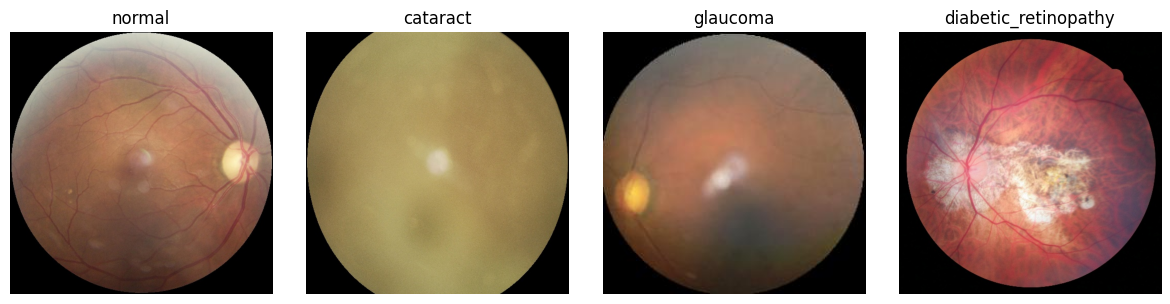

In [18]:
import os
base_dir = '/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
print(os.listdir(base_dir))  # Should see folders for each class
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"{class_name}: {len(os.listdir(class_dir))} images")
import matplotlib.pyplot as plt
from PIL import Image
import random

plt.figure(figsize=(12,3))
for i, class_name in enumerate(os.listdir(base_dir)):
    class_dir = os.path.join(base_dir, class_name)
    img_fname = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_fname)
    img = Image.open(img_path)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [19]:
import tensorflow as tf
import os

dataset_dir = '/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
batch_size = 32
img_size = (224, 224)  # Adjust if your model uses different size

# Prepare the dataset as one big test set
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',  # for one-hot labels
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # keep deterministic order
)

# Get class names
class_names = all_ds.class_names
print('Class order:', class_names)


Found 4217 files belonging to 4 classes.
Class order: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


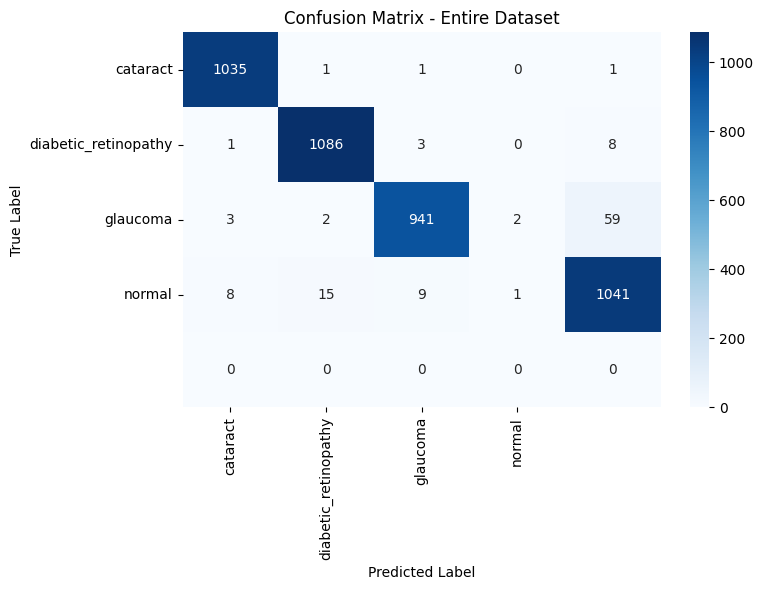

CLASSIFICATION REPORT:


ValueError: Number of classes, 5, does not match size of target_names, 4. Try specifying the labels parameter

In [20]:
import numpy as np

y_true = []
y_pred_proba = []
for images, labels in all_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    probs = model.predict(images, verbose=0)
    y_pred_proba.extend(probs)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Entire Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('CLASSIFICATION REPORT:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Per-class accuracy
for i, cname in enumerate(class_names):
    acc = 100 * cm[i, i] / cm[i, :].sum()
    print(f'{cname}: {acc:.2f}%  ({cm[i,i]}/{cm[i,:].sum()})')


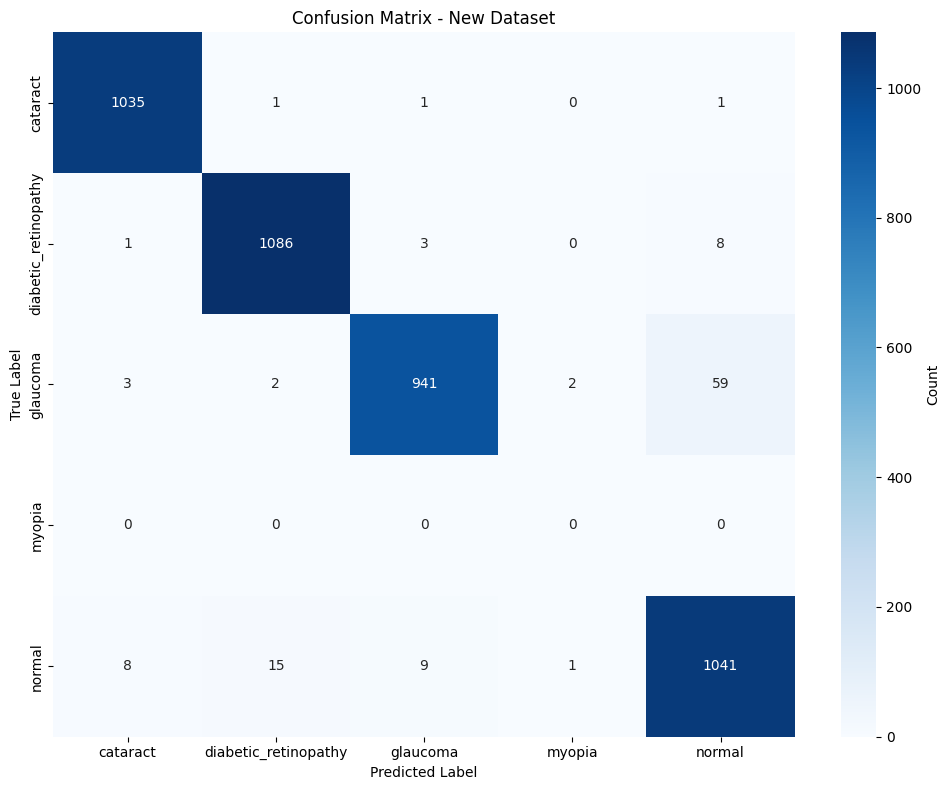


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9885    0.9971    0.9928      1038
diabetic_retinopathy     0.9837    0.9891    0.9864      1098
            glaucoma     0.9864    0.9345    0.9597      1007
              myopia     0.0000    0.0000    0.0000         0
              normal     0.9387    0.9693    0.9537      1074

            accuracy                         0.9730      4217
           macro avg     0.7795    0.7780    0.7785      4217
        weighted avg     0.9741    0.9730    0.9733      4217


PER-CLASS ACCURACY
cataract: 99.71% (1035/1038)
diabetic_retinopathy: 98.91% (1086/1098)
glaucoma: 93.45% (941/1007)
myopia: 0.00% (0/0)
normal: 96.93% (1041/1074)


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define ALL 5 classes your model was trained on (in the exact order)
model_class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']
# Adjust the order above to match YOUR model's training order!

# Get predictions
y_true = []
y_pred_proba = []

for images, labels in all_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

# Map the dataset class indices to your model's class indices
# Your dataset has: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
# Your model expects: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']
# Create mapping from dataset indices to model indices
dataset_classes = all_ds.class_names  # ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
model_to_dataset = {}
for i, name in enumerate(model_class_names):
    if name in dataset_classes:
        model_to_dataset[i] = dataset_classes.index(name)

# The key insight: your y_true uses dataset indices (0-3), 
# but y_pred uses model indices (0-4)
# We need to remap y_true to match model indices
y_true_remapped = []
for label in y_true:
    class_name = dataset_classes[label]
    model_idx = model_class_names.index(class_name)
    y_true_remapped.append(model_idx)
y_true_remapped = np.array(y_true_remapped)

# Now generate confusion matrix and report with all 5 classes
labels = list(range(len(model_class_names)))  # [0, 1, 2, 3, 4]

cm = confusion_matrix(y_true_remapped, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_class_names,
            yticklabels=model_class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - New Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_remapped, y_pred, 
                           labels=labels, 
                           target_names=model_class_names, 
                           digits=4,
                           zero_division=0))

print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(model_class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")
